In [1]:
import gymnasium as gym
import numpy as np

In [2]:
env = gym.make("Blackjack-v1", natural=True, sab=True)
def play_blackjack(env, num_episodes=1000):
    total_rewards = []
    
    for episode in range(num_episodes):
        obs, _ = env.reset()
        done = False
        total_reward = 0
        
        while not done:
            # Randomly choose an action: 0 for stick, 1 for hit
            action = env.action_space.sample()
            obs, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            total_reward += reward
        
        total_rewards.append(total_reward)
    
    return np.mean(total_rewards)

score = play_blackjack(env, num_episodes=1000)
print(f"Average score over 1000 episodes: {score:.2f}")


Average score over 1000 episodes: -0.38


In [3]:
env.action_space

Discrete(2)

In [4]:
total, card, ace = env.observation_space


In [5]:
total

Discrete(32)

### Monte Carlo Basic Implementation 

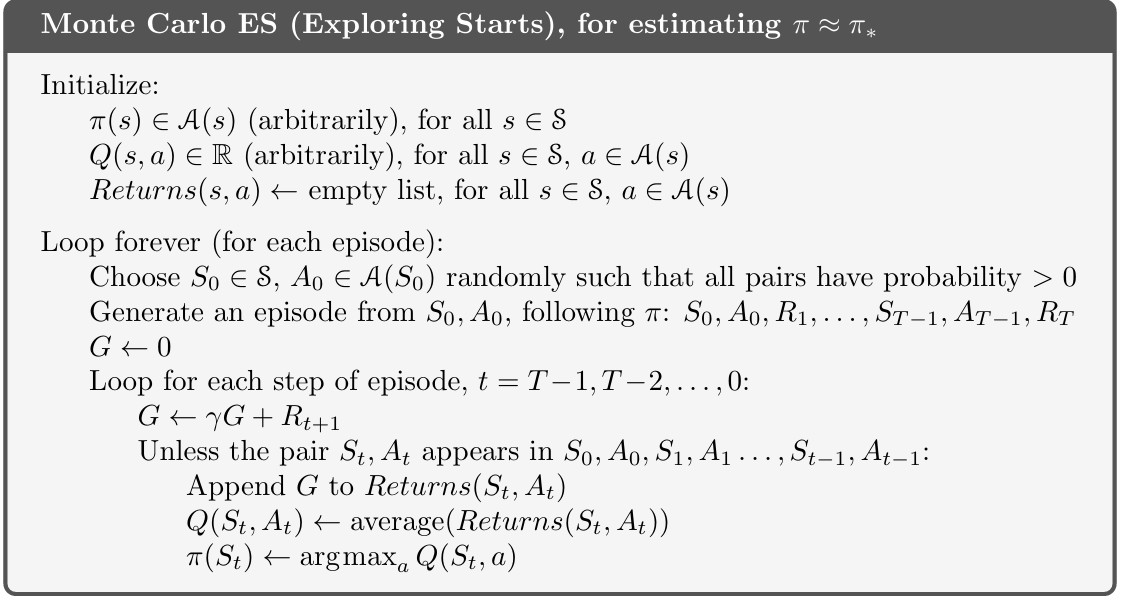

In [32]:
import numpy as np

class MCControl_ExploringStarts:
    def __init__(self, env, num_episodes=10000, gamma=0.9, epsilon=0.1):
        self.env = env
        self.num_episodes = num_episodes
        self.num_states = env.observation_space.n
        self.num_actions = env.action_space.n
        self.gamma = gamma
        self.epsilon = epsilon  
        self.Q = np.zeros((self.num_states, self.num_actions))
        self.returns = {s: {a: [] for a in range(self.num_actions)} for s in range(self.num_states)}

    def policy_improvement(self):
        """Creates a greedy policy based on current Q-values."""
        policy = np.zeros(self.num_states, dtype=int)
        for state in range(self.num_states):
            policy[state] = np.argmax(self.Q[state])
        return policy

    def get_action_from_q(self, state): 
        """Selects an action using an epsilon-greedy policy based on Q-values."""
        if np.random.rand() < self.epsilon:
            return self.env.action_space.sample()  # Explore
        else:
            return np.argmax(self.Q[state])  # Exploit

    def generate_episode(self, start_state, first_action):
        """Generates an episode starting with (start_state, first_action)
           and then follows the epsilon-greedy policy based on current Q."""
        episode = []
        obs, _ = self.env.reset()  # Reset the environment to start a new episode
        self.env = self.env.unwrapped  # Ensure we can access the P attribute for transition probabilities
        obs = start_state
        # next_obs, reward, terminated, truncated, _ = self.env.step(first_action)
        prob, next_obs, reward, done = self.env.P[obs][first_action][0] 
        episode.append((obs, first_action, reward))
        obs = next_obs

        while not done:
            action = self.get_action_from_q(obs) 
            # next_obs, reward, terminated, truncated, _ = self.env.step(action)
            prob, next_obs, reward, done = self.env.P[obs][action][0] 
            episode.append((obs, action, reward))
            obs = next_obs
        return episode

    def choose_exploring_start(self):
        """Randomly chooses a state and an action for an exploring start."""
        s = np.random.randint(self.num_states-1)  # Randomly select a state 
        a = self.env.action_space.sample()
        return s, a

    def train(self): 
        """Performs Monte Carlo control with Exploring Starts."""
        
        for epi in range(self.num_episodes):
            if epi % (self.num_episodes // 10) == 0 and self.num_episodes >= 100 : # Progress
                 print(f"Episode {epi}/{self.num_episodes} - Progress: {self.Q[14][2]}%")

            s0, a0 = self.choose_exploring_start()

            episode = self.generate_episode(s0, a0)
            
            G = 0
            visited_sa_in_episode = set() 

            for state, action, reward in reversed(episode):
                G = reward + self.gamma * G
                if (state, action) not in visited_sa_in_episode:
                    self.returns[state][action].append(G)
                    self.Q[state, action] = np.mean(self.returns[state][action])
                    visited_sa_in_episode.add((state, action))
            
        final_policy = self.policy_improvement()
        return final_policy, self.Q

env = gym.make("FrozenLake-v1", is_slippery=False, map_name="4x4")
mc_control = MCControl_ExploringStarts(env, num_episodes=4000, gamma=0.9, epsilon=0.1)
final_policy, Q_values = mc_control.train()
print("Final policy (action for each state):")
for state in range(mc_control.num_states):
    print(f"State {state}: Action {final_policy[state]} (Q-value: {Q_values[state, final_policy[state]]:.2f})")
print("Q-values for each state-action pair:")


Episode 0/4000 - Progress: 0.0%
Episode 400/4000 - Progress: 1.0%
Episode 800/4000 - Progress: 1.0%
Episode 1200/4000 - Progress: 1.0%
Episode 1600/4000 - Progress: 1.0%
Episode 2000/4000 - Progress: 1.0%
Episode 2400/4000 - Progress: 1.0%
Episode 2800/4000 - Progress: 1.0%
Episode 3200/4000 - Progress: 1.0%
Episode 3600/4000 - Progress: 1.0%
Final policy (action for each state):
State 0: Action 1 (Q-value: 0.39)
State 1: Action 2 (Q-value: 0.57)
State 2: Action 1 (Q-value: 0.66)
State 3: Action 0 (Q-value: 0.55)
State 4: Action 1 (Q-value: 0.53)
State 5: Action 0 (Q-value: 0.00)
State 6: Action 1 (Q-value: 0.77)
State 7: Action 0 (Q-value: 0.00)
State 8: Action 2 (Q-value: 0.63)
State 9: Action 1 (Q-value: 0.77)
State 10: Action 1 (Q-value: 0.89)
State 11: Action 0 (Q-value: 0.00)
State 12: Action 0 (Q-value: 0.00)
State 13: Action 2 (Q-value: 0.89)
State 14: Action 2 (Q-value: 1.00)
State 15: Action 0 (Q-value: 0.00)
Q-values for each state-action pair:


In [33]:
env.action_space.sample()

3

In [34]:
move_mapping = {
    0: "Left",
    1: "Down",
    2: "Right",
    3: "Up"
}

In [35]:
# print policy in a matrix format
policy_matrix = final_policy.reshape((4, 4))
print("Policy matrix:")
# print(policy_matrix)
for row in policy_matrix:
    print(" | ".join(move_mapping[action] for action in row))
    

Policy matrix:
Down | Right | Down | Left
Down | Left | Down | Left
Right | Down | Down | Left
Left | Right | Right | Left


In [ ]:
Q_values = np.max(Q_values, axis=1)
print("Q-values for each state:")
for state in range(mc_control.num_states):
    print(f"State {state}: Q-value {Q_values[state]:.2f}")


AxisError: axis 1 is out of bounds for array of dimension 1

'4x4'

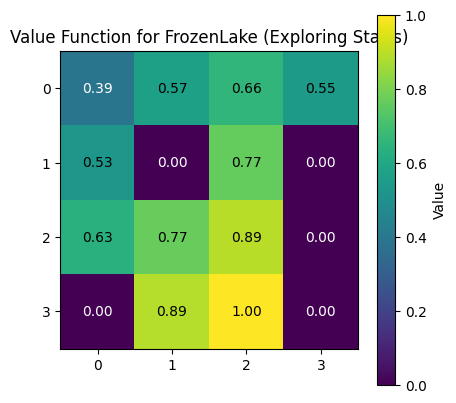

In [37]:
plot_value_function(Q_values, env_shape=(4,4) , title="Value Function for FrozenLake (Exploring Starts)")

## MCC For BlackJack enviorment 

In [10]:
import numpy as np
import gymnasium as gym # Use gymnasium for current Gym API
from collections import defaultdict

class MCControl_ExploringStarts_Blackjack:
    def __init__(self, env, num_episodes=100000, gamma=1.0): 
        self.env = env
        self.num_episodes = num_episodes
        self.num_actions = env.action_space.n
        self.gamma = gamma
        self.Q = defaultdict(lambda: np.zeros(self.num_actions))
        self.returns = defaultdict(lambda: defaultdict(list))
        self.epsilon = 0.1 
    def get_action_from_q(self, state):
        """Selects an action using an epsilon-greedy policy based on Q-values."""
        if np.random.rand() < self.epsilon:
            return self.env.action_space.sample()  # Explore
        else:
            return np.argmax(self.Q[state])  # Exploit

    def choose_exploring_start(self):
        """
        Chooses a starting state by resetting the environment
        and randomly selects an action for an exploring start.
        """
        start_state, _ = self.env.reset()
        first_action = self.env.action_space.sample() 
        return start_state, first_action

    def generate_episode(self, start_state, first_action):
        """
        Generates an episode starting with (start_state, first_action)
        and then follows an epsilon-greedy policy based on current Q.
        """
        episode = []
        obs = start_state 

        next_obs, reward, terminated, truncated, _ = self.env.step(first_action)
        done = terminated or truncated
        episode.append((obs, first_action, reward))
        obs = next_obs

        while not done:
            action = self.get_action_from_q(obs)
            next_obs, reward, terminated, truncated, _ = self.env.step(action)
            done = terminated or truncated
            episode.append((obs, action, reward))
            obs = next_obs
        return episode

    def train(self):
        """Performs Monte Carlo control with Exploring Starts."""
        for epi in range(self.num_episodes):
            if epi % (self.num_episodes // 20) == 0 and self.num_episodes >= 100:
                sample_blackjack_state = (18, 7, True) 
                sample_blackjack_state = (np.random.randint(12, 22), np.random.randint(1, 11), np.random.choice([True, False]))
                if sample_blackjack_state in self.Q:
                    q_val_stick = self.Q[sample_blackjack_state][0] 
                    q_val_hit = self.Q[sample_blackjack_state][1]  
                    print(f"Episode {epi}/{self.num_episodes} - Q(sum:18, deal:7, ace:T): Stick={q_val_stick:.3f}, Hit={q_val_hit:.3f}")
                else:
                    print(f"Episode {epi}/{self.num_episodes}")


            s0, a0 = self.choose_exploring_start()
            episode = self.generate_episode(s0, a0)

            G = 0
            visited_sa_in_episode = set()

            for state, action, reward in reversed(episode):
                G = reward + self.gamma * G
                if (state, action) not in visited_sa_in_episode:
                    self.returns[state][action].append(G)
                    self.Q[state][action] = np.mean(self.returns[state][action])
                    visited_sa_in_episode.add((state, action))

        final_policy = {}
        for state in self.Q.keys():
            final_policy[state] = np.argmax(self.Q[state])
        return final_policy, self.Q

if __name__ == '__main__':
    blackjack_env = gym.make("Blackjack-v1", natural=False, sab=False)

    mc_control_blackjack = MCControl_ExploringStarts_Blackjack(blackjack_env, num_episodes=10000, gamma=1.0)
    final_policy, Q_values = mc_control_blackjack.train()

    print("\nFinal Policy (selected examples):")
    count = 0
    sorted_policy_items = sorted(final_policy.items(), key=lambda item: (item[0][0], item[0][1], item[0][2]))

    for state, action in sorted_policy_items:
        player_sum, dealer_card, usable_ace = state
        if player_sum >= 17 or count < 20 : 
            action_str = "Stick (0)" if action == 0 else "Hit (1)"
            print(f"State (Sum:{player_sum}, Dealer:{dealer_card}, UsableAce:{usable_ace}): -> {action_str} "
                  f"(Q-values: Stick={Q_values[state][0]:.3f}, Hit={Q_values[state][1]:.3f})")
            count +=1
        if count >= 30 and player_sum < 17 : 
            if count == 30: print("...")
            count +=1 

    example_state = (20, 10, True) 
    if example_state in Q_values:
        print(f"\nQ-values for state {example_state}:")
        print(f"  Action Stick (0): {Q_values[example_state][0]:.3f}")
        print(f"  Action Hit (1): {Q_values[example_state][1]:.3f}")
        print(f"  Policy recommends: {'Stick (0)' if final_policy[example_state] == 0 else 'Hit (1)'}")
    else:
        print(f"\nState {example_state} not visited or Q-values not learned.")

    blackjack_env.close()

Episode 0/10000
Episode 500/10000 - Q(sum:18, deal:7, ace:T): Stick=0.333, Hit=0.000
Episode 1000/10000 - Q(sum:18, deal:7, ace:T): Stick=0.000, Hit=1.000
Episode 1500/10000
Episode 2000/10000 - Q(sum:18, deal:7, ace:T): Stick=0.778, Hit=-1.000
Episode 2500/10000 - Q(sum:18, deal:7, ace:T): Stick=-1.000, Hit=-0.857
Episode 3000/10000
Episode 3500/10000 - Q(sum:18, deal:7, ace:T): Stick=0.091, Hit=-0.385
Episode 4000/10000 - Q(sum:18, deal:7, ace:T): Stick=-1.000, Hit=-0.333
Episode 4500/10000 - Q(sum:18, deal:7, ace:T): Stick=-0.556, Hit=-0.571
Episode 5000/10000 - Q(sum:18, deal:7, ace:T): Stick=0.000, Hit=0.333
Episode 5500/10000 - Q(sum:18, deal:7, ace:T): Stick=0.000, Hit=1.000
Episode 6000/10000 - Q(sum:18, deal:7, ace:T): Stick=0.333, Hit=0.000
Episode 6500/10000 - Q(sum:18, deal:7, ace:T): Stick=1.000, Hit=0.111
Episode 7000/10000 - Q(sum:18, deal:7, ace:T): Stick=0.235, Hit=-0.444
Episode 7500/10000 - Q(sum:18, deal:7, ace:T): Stick=0.250, Hit=0.000
Episode 8000/10000 - Q(sum:1

### Gemini Code 

Observation Space: Discrete(16)
Action Space: Discrete(4)

--- Training Started ---
Episode 400/4000 completed. Avg Reward (last 10%): 0.01. Epsilon: 0.961
Episode 800/4000 completed. Avg Reward (last 10%): 0.03. Epsilon: 0.923
Episode 1200/4000 completed. Avg Reward (last 10%): 0.01. Epsilon: 0.887
Episode 1600/4000 completed. Avg Reward (last 10%): 0.06. Epsilon: 0.852
Episode 2000/4000 completed. Avg Reward (last 10%): 0.09. Epsilon: 0.819
Episode 2400/4000 completed. Avg Reward (last 10%): 0.08. Epsilon: 0.787
Episode 2800/4000 completed. Avg Reward (last 10%): 0.13. Epsilon: 0.756
Episode 3200/4000 completed. Avg Reward (last 10%): 0.15. Epsilon: 0.726
Episode 3600/4000 completed. Avg Reward (last 10%): 0.15. Epsilon: 0.698
Episode 4000/4000 completed. Avg Reward (last 10%): 0.18. Epsilon: 0.670
--- Training Finished ---


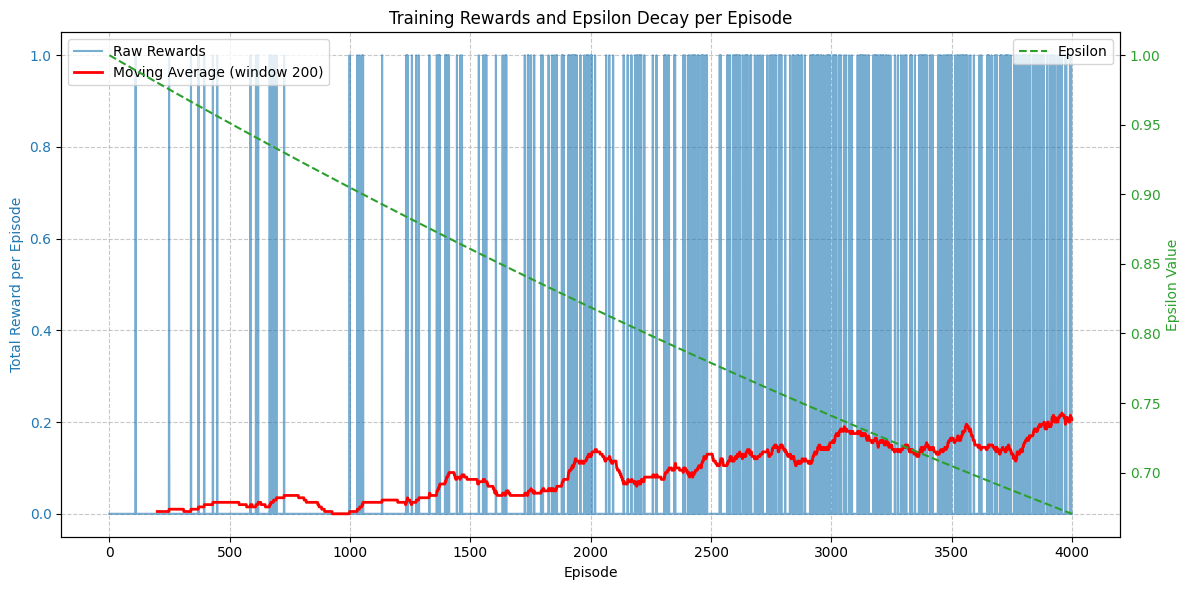

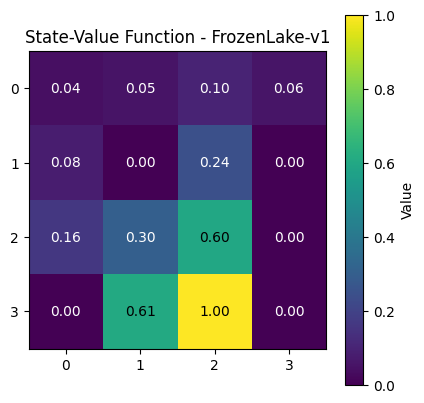

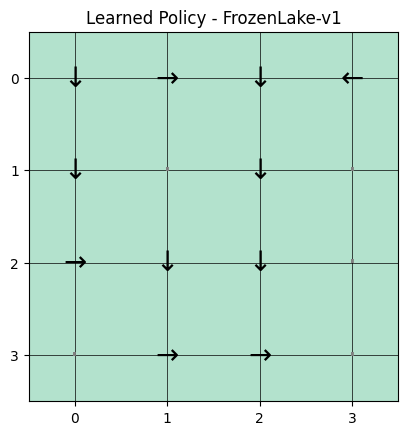


--- Testing the Learned Policy ---

--- Testing Finished ---
Average reward over 100 test episodes: 1.00
Success rate over 100 test episodes: 100.00%

--- Testing on Slippery FrozenLake ---

--- Testing Finished ---
Average reward over 100 test episodes: 0.04
Success rate over 100 test episodes: 4.00%


In [12]:
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym 

class MCControl:
    def __init__(self, env, num_episodes=1000, gamma=0.9, initial_epsilon=1.0, min_epsilon=0.01, epsilon_decay_rate=0.995):
        self.env = env
        self.num_episodes = num_episodes
        self.num_states = env.observation_space.n
        self.num_actions = env.action_space.n
        self.gamma = gamma
        self.initial_epsilon = initial_epsilon 
        self.epsilon = initial_epsilon
        self.min_epsilon = min_epsilon
        self.epsilon_decay_rate = epsilon_decay_rate
        self.Q = np.zeros((self.num_states, self.num_actions))
        self.returns = {s: {a: [] for a in range(self.num_actions)} for s in range(self.num_states)}
        self.episode_rewards = [] 
        self.episode_epsilon_values = [] 

    def get_action_from_policy(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.randint(self.num_actions)
        else:
            return np.argmax(self.Q[state])

    def generate_episode(self):
        episode = []
        current_total_reward = 0
        state, _ = self.env.reset()
        done = False
        while not done:
            action = self.get_action_from_policy(state)
            next_state, reward, done, _, _ = self.env.step(action)
            episode.append((state, action, reward))
            current_total_reward += reward
            state = next_state
        self.episode_rewards.append(current_total_reward) 
        return episode

    def update_Q(self, episode):
        G = 0
        visited_sa_pairs = set()
        for state, action, reward in reversed(episode):
            G = reward + self.gamma * G
            if (state, action) not in visited_sa_pairs:
                visited_sa_pairs.add((state, action))
                self.returns[state][action].append(G)
                self.Q[state][action] = np.mean(self.returns[state][action])

    def run(self):
        self.episode_rewards = [] 
        self.episode_epsilon_values = []
        self.epsilon = self.initial_epsilon 

        for episode_num in range(self.num_episodes):
            episode = self.generate_episode()
            self.update_Q(episode)
            
            self.episode_epsilon_values.append(self.epsilon) 
            if self.epsilon > self.min_epsilon:
                self.epsilon *= self.epsilon_decay_rate
                self.epsilon = max(self.min_epsilon, self.epsilon) 

            if (episode_num + 1) % (self.num_episodes // 10) == 0:
                avg_reward_last_10_percent = np.mean(self.episode_rewards[-(self.num_episodes // 10):])
                print(f"Episode {episode_num + 1}/{self.num_episodes} completed. Avg Reward (last 10%): {avg_reward_last_10_percent:.2f}. Epsilon: {self.epsilon:.3f}")
        return self.Q, self.episode_rewards, self.episode_epsilon_values

def test_policy(env, Q_table, num_episodes=100, render=False):
    total_reward = 0
    successful_episodes = 0
    for i in range(num_episodes):
        state, _ = env.reset()
        done = False
        episode_reward = 0
        if render and i < 5 : print(f"\n--- Test Episode {i+1} ---") 
        while not done:
            action = np.argmax(Q_table[state]) 
            state, reward, done, _, info = env.step(action)
            episode_reward += reward
            if render and i < 5:
                env.render()
                print(f"State: {state}, Action: {action}, Reward: {reward}, Done: {done}")
        total_reward += episode_reward
        if episode_reward > 0: 
            successful_episodes += 1
    average_reward = total_reward / num_episodes
    success_rate = successful_episodes / num_episodes
    print(f"\n--- Testing Finished ---")
    print(f"Average reward over {num_episodes} test episodes: {average_reward:.2f}")
    print(f"Success rate over {num_episodes} test episodes: {success_rate:.2%}")
    return average_reward, success_rate

# Visualization Functions
def plot_rewards(episode_rewards, episode_epsilon_values):
    fig, ax1 = plt.subplots(figsize=(12, 6))

    # Plot Rewards
    color = 'tab:blue'
    ax1.set_xlabel('Episode')
    ax1.set_ylabel('Total Reward per Episode', color=color)
    ax1.plot(episode_rewards, color=color, alpha=0.6, label='Raw Rewards')
    # Plot moving average of rewards
    window_size = len(episode_rewards) // 20 if len(episode_rewards) > 20 else len(episode_rewards)
    if window_size > 0:
        moving_avg = np.convolve(episode_rewards, np.ones(window_size)/window_size, mode='valid')
        ax1.plot(np.arange(window_size-1, len(episode_rewards)), moving_avg, color='red', linewidth=2, label=f'Moving Average (window {window_size})')
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.legend(loc='upper left')
    ax1.set_title('Training Rewards and Epsilon Decay per Episode')
    ax1.grid(True, linestyle='--', alpha=0.7)

    
    ax2 = ax1.twinx() 
    color = 'tab:green'
    ax2.set_ylabel('Epsilon Value', color=color)
    ax2.plot(episode_epsilon_values, color=color, linestyle='--', label='Epsilon')
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.legend(loc='upper right')

    fig.tight_layout() 
    plt.show()

def plot_value_function(Q_table, env_shape, title="State-Value Function (V(s))"):
    """Assumes env_shape is a tuple like (rows, cols) for a grid environment."""
    V = np.max(Q_table, axis=1)
    V_grid = V.reshape(env_shape)
    plt.figure(figsize=(env_shape[1]*1.2, env_shape[0]*1.2)) # Adjust size based on grid
    plt.imshow(V_grid, cmap='viridis', interpolation='nearest')
    plt.colorbar(label='Value')
    plt.title(title)
    plt.xticks(np.arange(env_shape[1]))
    plt.yticks(np.arange(env_shape[0]))
    # Add text annotations for values
    for i in range(env_shape[0]):
        for j in range(env_shape[1]):
            plt.text(j, i, f"{V_grid[i, j]:.2f}", ha="center", va="center", color="white" if V_grid[i,j] < V_grid.max()/2 else "black")
    plt.show()

def plot_policy(Q_table, env_shape, title="Learned Policy (π(s))"):
    """Assumes env_shape is a tuple like (rows, cols) for a grid environment.
       Maps actions (0:Left, 1:Down, 2:Right, 3:Up for FrozenLake).
       Adjust action_symbols if your environment has different action meanings.
    """
    policy = np.argmax(Q_table, axis=1)
    policy_grid = policy.reshape(env_shape)
    
    # For FrozenLake: 0: Left, 1: Down, 2: Right, 3: Up
    action_symbols = {0: '←', 1: '↓', 2: '→', 3: '↑'} 
    # For other environments, you might need different symbols or a different mapping
    # e.g. action_symbols = {i: str(i) for i in range(Q_table.shape[1])}

    plt.figure(figsize=(env_shape[1]*1.2, env_shape[0]*1.2))
    plt.imshow(np.zeros(env_shape), cmap='Pastel2', interpolation='nearest') # Dummy background
    plt.title(title)
    plt.xticks(np.arange(env_shape[1]))
    plt.yticks(np.arange(env_shape[0]))
    plt.grid(True, linestyle='-', color='black', linewidth=0.5)

    for i in range(env_shape[0]):
        for j in range(env_shape[1]):
            action = policy_grid[i, j]
            symbol = action_symbols.get(action, str(action)) # Default to number if not in map
            # Check if Q-values for this state are all zero (or very close)
            # If so, it might be an unvisited/unimportant state, don't draw an arrow
            if not np.all(np.isclose(Q_table[i*env_shape[1]+j], 0)):
                 plt.text(j, i, symbol, ha="center", va="center", fontsize=20, color="black")
            else:
                 plt.text(j, i, "·", ha="center", va="center", fontsize=20, color="gray") # mark for unvisited states
    plt.show()


# --- Example Usage with FrozenLake ---
if __name__ == '__main__':
    # For FrozenLake, a 4x4 grid, so env_shape = (4, 4)
    # You can try is_slippery=False for a deterministic environment first
    env_name = 'FrozenLake-v1'
    env = gym.make(env_name, is_slippery=False) # render_mode="human" can be used for live rendering in test_policy

    print(f"Observation Space: {env.observation_space}")
    print(f"Action Space: {env.action_space}")

    num_train_episodes = 4000
    mc_control = MCControl(env, num_episodes=num_train_episodes, initial_epsilon=1.0, min_epsilon=0.01, epsilon_decay_rate=0.9999)
    
    print("\n--- Training Started ---")
    Q_final, rewards_history, epsilon_history = mc_control.run()
    print("--- Training Finished ---")
    env.close() # Close training environment

    # Plotting training progress
    plot_rewards(rewards_history, epsilon_history)

    # For grid-like environments like FrozenLake (4x4 states = 16)
    env_shape = None
    if hasattr(env, 'desc'): # FrozenLake has a 'desc' attribute describing the map
        env_shape = env.desc.shape
    elif env.observation_space.n == 16: # Common for 4x4 FrozenLake
        env_shape = (4,4)
    elif env.observation_space.n == 64: # Common for 8x8 FrozenLake
        env_shape = (8,8)
    # Add more conditions if needed for other environments, or pass env_shape manually

    if env_shape:
        plot_value_function(Q_final, env_shape, title=f"State-Value Function - {env_name}")
        plot_policy(Q_final, env_shape, title=f"Learned Policy - {env_name}")
    else:
        print("\nSkipping grid visualizations as env_shape could not be determined.")
        print("Final Q-table head:")
        print(Q_final[:5])


    # Test the learned policy in a new environment instance
    print("\n--- Testing the Learned Policy ---")
    # test_env = gym.make(env_name, is_slippery=False, render_mode="human") # to see it run
    test_env = gym.make(env_name, is_slippery=False)
    test_policy(test_env, Q_final, num_episodes=100, render=False) # set render=True to see a few episodes
    test_env.close()

    # If you want to test the slippery version:
    print("\n--- Testing on Slippery FrozenLake ---")
    slippery_env = gym.make(env_name, is_slippery=True)
    test_policy(slippery_env, Q_final, num_episodes=100)
    slippery_env.close()